## 6️⃣ ML Model Training

In [1]:
# Load libraries
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import ElasticNet, Lasso, Ridge
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import pickle

# import helper functions made ad-hoc
from R3_functions import chain_snap
from R4_functions import regression_report_in_sample_out_of_sample
from R6_functions import check_grid_search_hyperparameters, construct_preprocessor

# Set random seed
np.random.seed(42)

**1. Load the train and validation datasets used in section 4️⃣ Create a baseline Model and carry out data cleaning procedure based on the previous findings**

In [2]:
DATA_TRAIN_PATH = os.path.join("data", "data_train_processed.parquet")
DATA_VAL_PATH = os.path.join("data", "data_val_processed.parquet")

In [3]:
# Load train and validation set

data_train = (
    pd.read_parquet(DATA_TRAIN_PATH)
    # drop Address and Zipcode as they are not useful
    .drop(columns=["Address", "Zip"])
    # Drop Lat and Lon
    .drop(columns=["Lat", "Lon"])
    # Drop Delivery Area as it contains too many categories
    .drop(columns=["Delivery_area"])
    # Discard all rows with values Price > 2M
    .loc[lambda x: x.Price < 2e6]
    # Double check nan values as sklearn does not like them
    .pipe(chain_snap, fn=lambda x: x.shape, msg="• Size dataframe")
    .pipe(
         chain_snap, fn=lambda x: x.isna().sum().sum(), msg="• Count NaNs post processing"
    )
    .pipe(chain_snap, fn=lambda x: display(x.head(2)), msg="• Train data head")
)

data_val = (
    pd.read_parquet(DATA_VAL_PATH)
    # drop Address and Zipcode as they are not useful
    .drop(columns=["Address", "Zip"])
    # Drop Lat and Lon
    .drop(columns=["Lat", "Lon"])
    # Drop Delivery Area as it contains too many categories
    .drop(columns=["Delivery_area"])
    # Discard all rows with values Price > 2M
    .loc[lambda x: x.Price < 2e6]
    # Double check nan values as sklearn does not like them
    .pipe(
         chain_snap, fn=lambda x: x.isna().sum().sum(), msg="Count NaNs post processing"
    )
    .pipe(chain_snap, fn=lambda x: x.shape, msg="Size dataframe")
    .pipe(chain_snap, fn=lambda x: display(x.head(2)), msg="Validation data head")
)

# let's consider Price and log(Price) as target. Depending on the model we will use one or the other
TARGET = ["Price", "log(Price)"]

• Size dataframe: (543, 15)
• Count NaNs post processing: 0


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,635000.0,81.0,3.0,13.36138,4.394449,1.098612,1078,0,7,8,27.0,3.295837,3.317122,3.346089,0.031533
1,400000.0,61.0,2.0,12.89922,4.110874,0.693147,1057,0,5,7,30.5,3.417727,1.947822,2.348155,0.036792


• Train data head: None
Count NaNs post processing: 0
Size dataframe: (181, 15)


,Price,Area,Room,log(Price),log(Area),log(Room),Zip_num,Region,Location,District,AR-ratio,log(AR-ratio),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000.0,68,3,12.959844,4.219508,1.098612,1098,0,9,8,22.666667,3.120895,3.606198,4.174069,0.071974
1,285000.0,96,4,12.560244,4.564348,1.386294,1104,1,0,4,24.000000,3.178054,7.350449,8.209335,0.135124


Validation data head: None


In [4]:
# split train and validation set into X and Y: Note that Y_train and Y_val contrains both Price and log(Price)
X_train, Y_train = data_train.drop(TARGET, axis=1), data_train[TARGET]
X_val, Y_val = data_val.drop(TARGET, axis=1), data_val[TARGET]

**2. Discard or fill in missing values using [imputation techniques](https://www.kaggle.com/code/residentmario/simple-techniques-for-missing-data-imputation), e.g., using the median value**

🙋‍♀️ scikit-learn will raise an error during training if the data contains Nan values;

- Small proportion of missing data (0.03%) has been observed in target variable (i.e, Price), since it was dropped previously, therefore no need to proceed this step. 

In [5]:
if len(data_train)==len(data_train.dropna()):
    print('• No missing values in train dataset')

if len(data_val)==len(data_val.dropna()):
    print('• No missing values in validation dataset')


• No missing values in train dataset
• No missing values in validation dataset


**3. Select a [cross-validation schema](https://scikit-learn.org/stable/modules/cross_validation.html) and an [evaluation metric](https://scikit-learn.org/stable/modules/model_evaluation.html) to be used for the hyperparameter tuning**

In [6]:
# Set parameters for grid search
scoring = (
    "r2"  # type of metrics used to select the best model during hyperparameters tuning
)
cv = 5  # 5-fold cross-validation

# Initialize empty dictionary and dataframe to store models and results, respectively
ml_models, df_report_all = {}, pd.DataFrame()

**4. Select features that have shown a reasonable predictive power with the target variable**	

💁‍♂️ You can further reduce the number of features by applying [feature selection techniques](https://neptune.ai/blog/feature-selection-methods), such as wrapper and embedded methods.

* First, using a wrapper method for feature selection:
    
    - Recursive feature elimination (REF):  this wrapper method returns features based on feature ranking with recursive feature elimination. The method itself utilises external estimator that assigns weights to the features. To do so, the estimator is trained on all features and each feature's importance is obtained through coeff_ or feature_importances_attribute. The least important feature is removed and this procedure is repeated until the desired number of features are selected.

In [7]:
# Adopting the wrapper method for feature selection
from sklearn.feature_selection import RFE #,RFECV
svr = SVR(kernel='linear')
rfe = RFE(svr, n_features_to_select=0.8, step=1)
# rfe = RFECV(svr, step = 1 , cv = 5, scoring = 'r2')
rfe.fit(X_train, Y_train['log(Price)'])
X_selection_train = rfe.transform(X_train)

#returning the best performing features:
X_train_wrapper = X_train.columns[rfe.support_].tolist()
#returning the best performing features across train and validation dataset:
print(f"• RFE wrapper method suggested the best features are: {str(X_train_wrapper)[1:-1]}")

• RFE wrapper method suggested the best features are: 'Room', 'log(Area)', 'log(Room)', 'Region', 'Location', 'District', 'log(AR-ratio)', 'Euclidean_distance', 'Haversine_distance', 'Manhattan_distance'


* Results from RFE indicated consistent results from previous workbooks: 
    - Regarding selected numeric features, all highly correlated features to target variable is maintained. Similarly, we will only select `Manhattan_distance` among all tranformed distance variable, based on its shows strongest correclation to target 
    - Regarding nominal (categorical) features, `['Region', 'Location', 'District']` were selected. However, we learned that `District` has displayed small variation on target variable, and when including it, most of the groups are not exhibiting statsitically significant effect on `log(Price)`. Therefore, it will be discarded when training the model. 

In [8]:
# Get subset of features coming from previous analysis to be used for model training
numerical_features = ["log(Area)", "log(Room)", "log(AR-ratio)", "Manhattan_distance"]
nominal_features = ["Region", "Location"]
target = "log(Price)"

# subset original dataframe to keep only the features we want to use
X_train_sk, y_train_sk = X_train[numerical_features + nominal_features], Y_train[target]
X_val_sk, y_val_sk = X_val[numerical_features + nominal_features], Y_val[target]

**5. Select the type of machine learning model and identify a hyperparameter set you want to tune during the learning process.** 

Check this [link](https://scikit-learn.org/stable/supervised_learning.html) for a complete list of models available on scikit-learn.

⭐️ It is recommended to train a [sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) which includes the data transformations such as [OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) combined with the model. In this way, you will significantly reduce bugs and simplify the code during the deployment phase.


**Train regularized Linear Regression**

Train regularized version of Linear Regression, namely: [*Ridge*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [*Lasso*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [*ElasticNet*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) regression. 

Since they are an extension of Linear Regression, one should still comply with the model assumption, e.g. normal distribution. Since these models can carry out feature selection (embedded methods), we can relax the condition of having a feature set with a VIF score > 5 and let the model decide the optimal weights for each feature. 

<!-- 💡 The code below has been written in such a way that one can select among the three types of model above mentioned. -->

In [27]:
# Option 1: Ridge, Option 2: Lasso, Option 3: ElasticNet
model_type = "ElasticNet"

# Set hyperparameter range
n_alphas = 100
alpha_range = np.linspace(1e-3, 25, n_alphas)

# Select model type
if model_type == "Ridge":
    model = Ridge(fit_intercept=True)
elif model_type == "Lasso":
    model = Lasso(fit_intercept=True)
elif model_type == "ElasticNet":
    model = ElasticNet(fit_intercept=True)
else:
    raise ValueError("Model type not supported")

In [28]:
# Construct the ml pipeline
ml_candidate_lr_reg = Pipeline(
    steps=[
        ("preprocessor", construct_preprocessor(numerical_features, nominal_features)),
        (model_type, model),
    ]
)

display(ml_candidate_lr_reg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('ElasticNet', ElasticNet())])

**6. Train the model in cross-validation while optimising the hyperparameters.** 

If the optimal value of a hyperparameter is at the edge of the selected range, enlarge the range and newly train the model. For this task, we will use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

* Note: When dealing with a large sample size, one should consider using [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [29]:
param_grid = {f"{model_type}__alpha": alpha_range}

# Construct the grid search
gridCV = GridSearchCV(
    estimator=ml_candidate_lr_reg,  # model to train
    param_grid=param_grid,          # hyperparameters to tune
    n_jobs=-1,                      # use all cores
    cv=cv,
    verbose=0,
    refit=True,                     # refit the best model on the whole dataset
    scoring=scoring,                # metrics to optimize
)

# Train the model and optimize for the best alpha
_ = gridCV.fit(X_train_sk, y_train_sk)

# Save the best alpha (hyperparameter)
best_alpha = gridCV.best_params_[f"{model_type}__alpha"]

# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# Store the trained model with hyperparameter tuned in the dictionary
ml_models[model_type] = gridCV.best_estimator_

**Note:** Due to convergency issue, Lasso and ElasticNet cannot have alpha < 0.001 

**7. Study the impact of the hyperparameters on the model performance and, if the model allows, assess the importance of each feature.** 

In [30]:
# Initialize a dataframe to store the coefficients of the model for each alpha
df_alphas = pd.DataFrame(
    index=alpha_range,
    columns=numerical_features
    + list(
        gridCV.best_estimator_["preprocessor"]
        .transformers_[1][1]["nominal_encoder"]
        .get_feature_names_out(input_features=nominal_features)
    ),
)

# Loop over the alphas and store the coefficients of the model for each alpha
for a in alpha_range:
    ml_candidate_lr_reg[model_type].set_params(alpha=a)
    ml_candidate_lr_reg.fit(X_train_sk, y_train_sk)

    # store the coefficients of the model for each alpha
    df_alphas.loc[a] = ml_candidate_lr_reg[model_type].coef_

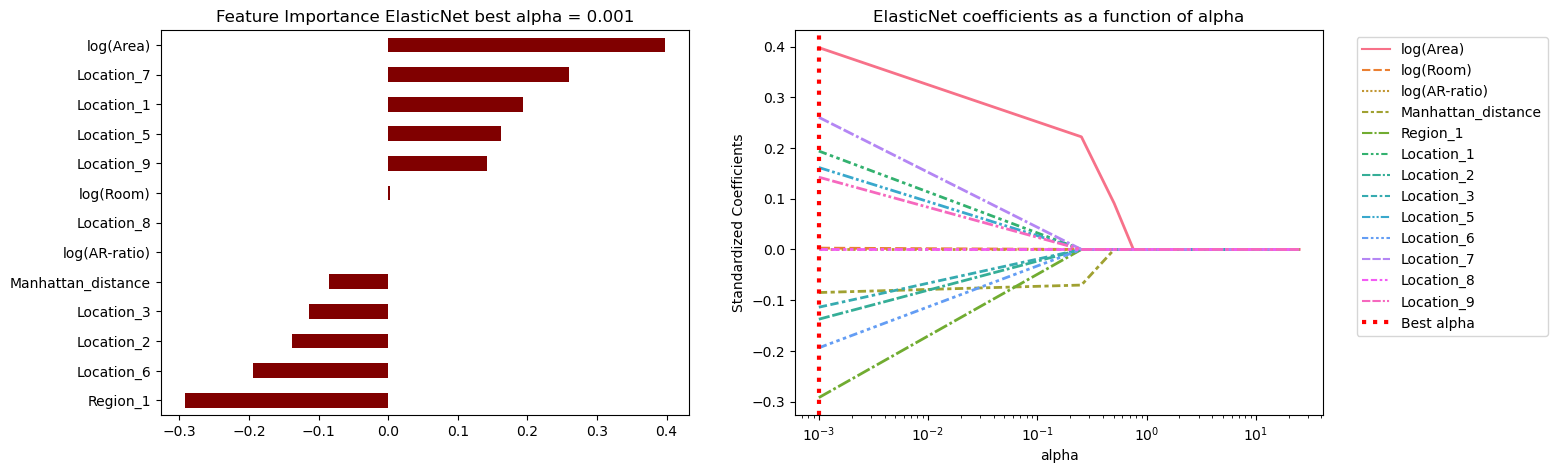

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df_alphas.loc[best_alpha, :].sort_values().plot(
    kind="barh",
    color='maroon',
    title=f"Feature Importance {model_type} best alpha = {best_alpha:.3f}",
    ax=axs[0],
)

sns.lineplot(
    data=df_alphas,
    ax=axs[1],
    linewidth=2,
)

# set x-axis to log scale
axs[1].set_xscale("log")

# add vertical line to indicate the best alpha
plt.axvline(
    best_alpha,
    linestyle=":",
    color='r',
    linewidth=3,
    label="Best alpha",
)

axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Standardized Coefficients")
axs[1].set_title(f"{model_type} coefficients as a function of alpha")

# # move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Save the figure generated above as png file.

In [39]:
# create img folder if not exists
if not os.path.exists("img"):
    os.makedirs("img")

# save the figure
fig.savefig(f"img/{model_type}_coefficients.png", bbox_inches="tight")

**8. Measure the model performance and keep in memory the trained models.**

In [32]:
# The model has already been stored in the dictionary ml_models
print("ML model type: ", model_type)
ml_models.keys()

ML model type:  ElasticNet


dict_keys(['Ridge', 'Lasso', 'ElasticNet'])

In [33]:
# evalutate model performance in train and validation set
y_fit = np.exp(gridCV.best_estimator_.predict(X_train_sk))
y_pred = np.exp(gridCV.best_estimator_.predict(X_val_sk))

# create dataframe with regression report
df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_sk),
    y_fit=y_fit,
    y_test=np.exp(y_val_sk),
    y_pred=y_pred,
    model_name=f"{model_type} (<2M)",
)

# display report
display(df_report)

# append to dataframe
df_report_all = pd.concat([df_report_all, df_report])

in-sample  out-of-sample  \
model            metrics                                         
ElasticNet (<2M) r-squared                0.839          0.776   
                 explained variance       0.841          0.783   
                 RMSE                128015.560     160847.612   
                 MAE                  76295.585      94241.836   
                 max error           936922.104    1026379.548   

                                     Difference (%)  \
model            metrics                              
ElasticNet (<2M) r-squared                -8.118557   
                 explained variance       -7.407407   
                 RMSE                     20.411899   
                 MAE                      19.042765   
                 max error                 8.715825   

                                                        Description  
model            metrics                                             
ElasticNet (<2M) r-squared             Coefficient of Determination  
                 explained variance        Explained Variance Score  
                 RMSE                Root Mean Squared Error (RMSE)  
                 MAE                      Mean Absolute Error (MAE)  
                 max error               The maximum residual error

**9. Train several models by repeating the abovementioned procedure**

**A. Train a Support Vector Machine (SVM)**

* Train [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html):

    * As in the previous case, we can relax the condition of having a feature set with a VIF score > 5 and let the model decide the optimal weights for each feature via its regularization term `C`. 

In [36]:
# Get subset of features to be used in the model
numerical_features = ["log(Area)", "log(Room)", "log(AR-ratio)", "Manhattan_distance"]
nominal_features = ["Region", "Location"]
target = "log(Price)"

# subset original dataframe to keep only the features we want to use
X_train_sk, y_train_sk = X_train[numerical_features + nominal_features], Y_train[target]
X_val_sk, y_val_sk = X_val[numerical_features + nominal_features], Y_val[target]

In [37]:
# Construct a sklearn pipeline
model_type = "SVM"
ml_candidate_SVM = Pipeline(
    steps=[
        ("preprocessor", construct_preprocessor(numerical_features, nominal_features)),
        (model_type, SVR(kernel="rbf")),  # fix type of Kernel
    ]
)

# visualize the pipeline
ml_candidate_SVM

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('SVM', SVR())])

In [38]:
# set hyperparameter range
param_grid = {
    f"{model_type}__C": np.linspace(0.01, 1, 20, endpoint=True),
}

# Construct the grid search
gridCV = GridSearchCV(
    estimator=ml_candidate_SVM,  # model to train
    param_grid=param_grid,  # hyperparameters to tune
    n_jobs=-1,  # use all cores
    cv=cv,
    verbose=0,
    refit=True,  # refit the best model on the whole dataset
    scoring=scoring,  # metrics to optimize
)

# Train the model and optimize for the best hyperparameter
_ = gridCV.fit(X_train_sk, y_train_sk)

# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# Store the trained model with hyperparameter tuned in the dictionary
ml_models[model_type] = gridCV.best_estimator_

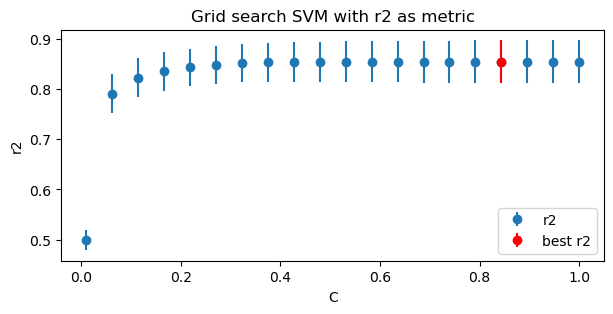

In [39]:
# plot mean_crossval_score vs hyperparameter with std_test_score as error bar
best_index = np.argmax(gridCV.cv_results_["mean_test_score"])

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))

axs.errorbar(
    list(gridCV.cv_results_[f"param_{model_type}__C"]),
    list(gridCV.cv_results_["mean_test_score"]),
    yerr=gridCV.cv_results_["std_test_score"],
    fmt="o",
    label=scoring,
)

axs.errorbar(
    list(gridCV.cv_results_[f"param_{model_type}__C"])[best_index],
    list(gridCV.cv_results_["mean_test_score"])[best_index],
    yerr=gridCV.cv_results_["std_test_score"][best_index],
    fmt="o",
    color="red",
    label=f"best {scoring}",
)

axs.set_xlabel("C")
axs.set_ylabel(scoring)
axs.set_title(f"Grid search {model_type} with {scoring} as metric")

plt.legend()
plt.show()

In [40]:
# evalutate model performance in train and validation set
y_fit = np.exp(gridCV.best_estimator_.predict(X_train_sk))
y_pred = np.exp(gridCV.best_estimator_.predict(X_val_sk))

df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_sk),
    y_fit=y_fit,
    y_test=np.exp(y_val_sk),
    y_pred=y_pred,
    model_name=f"{model_type} (<2M)",
)

# display report
display(df_report)

# append to dataframe
df_report_all = pd.concat([df_report_all, df_report])

in-sample  out-of-sample  Difference (%)  \
model     metrics                                                         
SVM (<2M) r-squared                0.888          0.767      -15.775750   
          explained variance       0.889          0.775      -14.709677   
          RMSE                106966.148     164174.974       34.846253   
          MAE                  62828.520      94789.639       33.717946   
          max error           838421.432     958934.445       12.567388   

                                                 Description  
model     metrics                                             
SVM (<2M) r-squared             Coefficient of Determination  
          explained variance        Explained Variance Score  
          RMSE                Root Mean Squared Error (RMSE)  
          MAE                      Mean Absolute Error (MAE)  
          max error               The maximum residual error

**B. Train a regression model with ensemble methods**

* Train a regression model with ensemble methods:
    - [*Random Forest*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)/[Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor): 
        * As in the previous case, we can relax the condition of having a feature set with a VIF score > 5 and let the model decide the optimal weights for each feature via its regularization term `max_depth`. 

In [41]:
# Get subset of features to be used in the model
numerical_features = ["log(Area)", "log(Room)", "log(AR-ratio)", "Manhattan_distance"]
nominal_features = ["Region", "Location"]
target = "log(Price)"

# subset original dataframe to keep only the features we want to use
X_train_sk, y_train_sk = X_train[numerical_features + nominal_features], Y_train[target]
X_val_sk, y_val_sk = X_val[numerical_features + nominal_features], Y_val[target]

In [57]:
# Option 1: RandomForest, Option 2: GradientBoosting
model_type = "RandomForest"

# Number of trees in random forest
n_estimators_range= np.arange(1,45,3) #np.linspace(1, 100, num = 10, dtype=int)

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth_range= np.arange(1,25,5) #[int(x) for x in np.linspace(1, 200, num = 15)] #

# Select model type
if model_type == "RandomForest":
    model = RandomForestRegressor()
# elif model_type == "AdaBoost":
#     model = AdaBoostRegressor()
elif model_type == "GradientBoosting":
    model = GradientBoostingRegressor()
else:
    raise ValueError("Model type not supported")

In [58]:
# Construct the ml pipeline
ml_candidate_em = Pipeline(
    steps=[
        ("preprocessor", construct_preprocessor(numerical_features, nominal_features)),
        (model_type, model),
    ]
)

display(ml_candidate_em)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('RandomForest', RandomForestRegressor())])

In [59]:
param_grid = {f"{model_type}__max_depth": max_depth_range,
              f"{model_type}__n_estimators": n_estimators_range}

# Construct the grid search
gridCV = GridSearchCV(
    estimator=ml_candidate_em,  # model to train
    param_grid=param_grid,      # hyperparameters to tune
    n_jobs=-1,                  # use all cores
    cv=cv,
    verbose=0,
    refit=True,                 # refit the best model on the whole dataset
    scoring=scoring,            # metrics to optimize
)

# Train the model and optimize for the best alpha
_ = gridCV.fit(X_train_sk, y_train_sk)

# Save the best hyperparameter
best_hyperparameter= gridCV.best_params_

# check grid search hyperparameters if they are in the range limit
check_grid_search_hyperparameters(gridCV, param_grid)

# Store the trained model with hyperparameter tuned in the dictionary
ml_models[model_type] = gridCV.best_estimator_

In [60]:
gridCV.best_params_

{'RandomForest__max_depth': 21, 'RandomForest__n_estimators': 43}

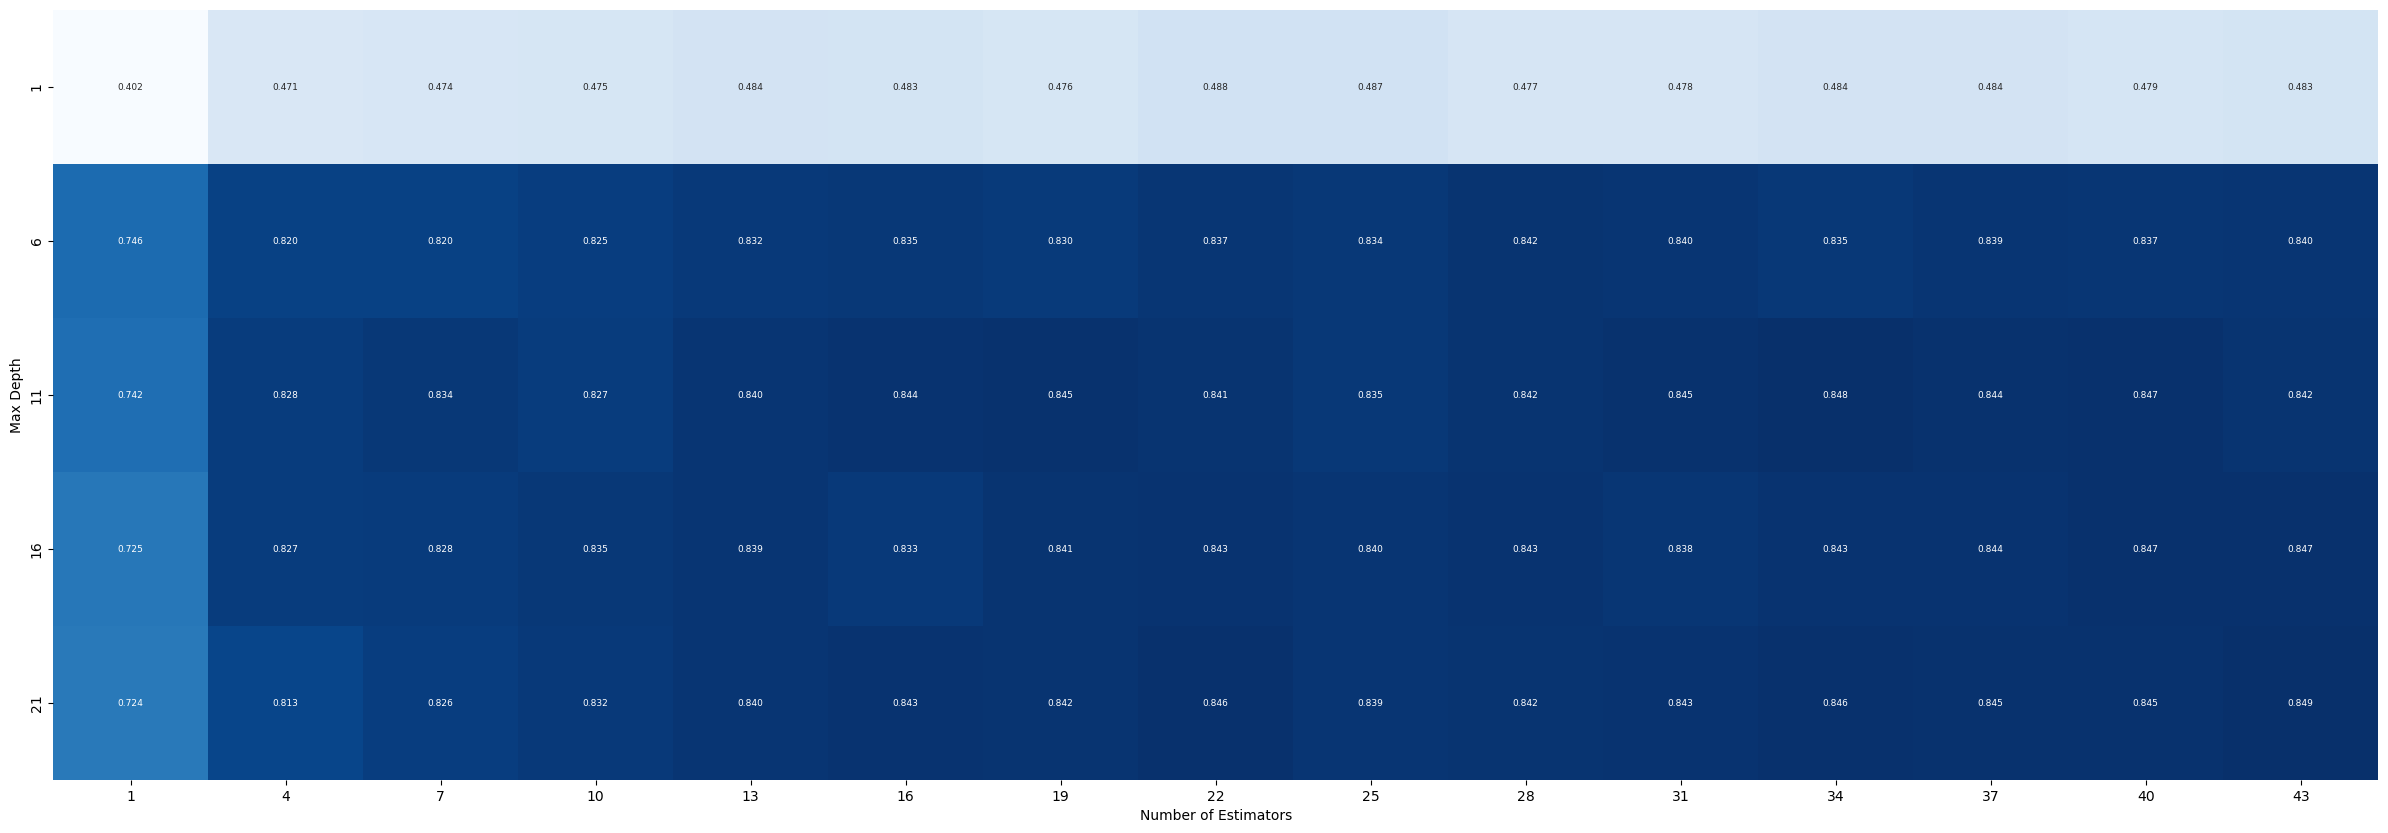

In [61]:
# Reshape the mean test scores to match the grid search dimensions
scores_matrix = gridCV.cv_results_["mean_test_score"].reshape(len(max_depth_range), len(n_estimators_range))
plt.figure(figsize=(30, 10)) 
# visualise the heatmap
sns.heatmap(scores_matrix,
            xticklabels=n_estimators_range,
            yticklabels=max_depth_range,
            annot=True,
            fmt='.3f',
            cmap='Blues',
            cbar=False,
            annot_kws={"fontsize": 6.5},
            # linewidths=0.5
            )

# Adding axis titles
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')

# Display the plot
plt.show()


In [62]:
# evalutate model performance in train and validation set
y_fit = np.exp(gridCV.best_estimator_.predict(X_train_sk))
y_pred = np.exp(gridCV.best_estimator_.predict(X_val_sk))

df_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_sk),
    y_fit=y_fit,
    y_test=np.exp(y_val_sk),
    y_pred=y_pred,
    model_name=f"{model_type} (<2M)",
)

# display report
display(df_report)

# append to dataframe
df_report_all = pd.concat([df_report_all, df_report])

in-sample  out-of-sample  \
model              metrics                                         
RandomForest (<2M) r-squared                0.967          0.748   
                   explained variance       0.967          0.754   
                   RMSE                 58369.178     170641.849   
                   MAE                  32048.513     101790.801   
                   max error           522404.659    1029729.116   

                                       Difference (%)  \
model              metrics                              
RandomForest (<2M) r-squared               -29.278075   
                   explained variance      -28.249337   
                   RMSE                     65.794336   
                   MAE                      68.515315   
                   max error                49.267759   

                                                          Description  
model              metrics                                             
RandomForest (<2M) r-squared             Coefficient of Determination  
                   explained variance        Explained Variance Score  
                   RMSE                Root Mean Squared Error (RMSE)  
                   MAE                      Mean Absolute Error (MAE)  
                   max error               The maximum residual error

Elapsed time to compute the importances: 5.099 seconds


<Figure size 800x300 with 0 Axes>

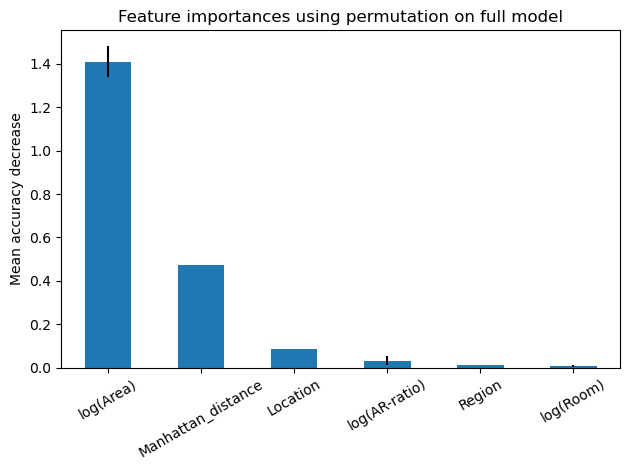

In [63]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()

result = permutation_importance(
    gridCV, X_train_sk, y_train_sk, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train_sk.columns)
sorted_importances_rf = forest_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 3)) 
fig, ax = plt.subplots()
sorted_importances_rf.plot.bar(yerr=result.importances_std, ax=ax)
plt.xticks(rotation=30)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

**10. compare their performance and pick the best-performing model (don't forget to compare them models against the baseline model).**

In [16]:
# Get list of folder in artifacts
artifacts_filelist = os.listdir("artifacts")

# Select the folder name in list which contains the string "baseline"
baseline_path = [s for s in artifacts_filelist if "baseline" in s][0]

baseline_filelist = os.listdir(os.path.join("artifacts", baseline_path))
# Select the file name in list which contains the string "performance"
baseline_performance_file = [s for s in baseline_filelist if "performance" in s][0]

performance_file = os.path.join("artifacts", baseline_path, baseline_performance_file)

print("• Loading baseline performance file from: \n ", performance_file)
# Load csv file. Note. We apply reset_index().set_index() to be able to merge the dataframe afterwards
df_baseline = (
    pd.read_csv(performance_file, index_col=0)
    .reset_index()
    .set_index(["model", "metrics"])
)

• Loading baseline performance file from: 
  artifacts/2024-01-11-08-37-12_baseline_model/baseline_model_performance.csv


In [55]:
# Concatenate baseline to existing dataframe
df_report_all = pd.concat([df_baseline, df_report_all])
display(df_report_all)

in-sample  out-of-sample  \
model                  metrics                                         
OLS (<2M)              r-squared                0.786          0.716   
                       explained variance       0.789          0.729   
                       RMSE                147571.708     181023.072   
                       MAE                  91023.514     111734.697   
                       max error           897621.898     989269.060   
                       r-squared                0.786          0.716   
                       explained variance       0.789          0.729   
                       RMSE                147571.708     181023.072   
                       MAE                  91023.514     111734.697   
                       max error           897621.898     989269.060   
                       r-squared                0.786          0.716   
                       explained variance       0.789          0.729   
                       RMSE                147571.708     181023.072   
                       MAE                  91023.514     111734.697   
                       max error           897621.898     989269.060   
                       r-squared                0.786          0.716   
                       explained variance       0.789          0.729   
                       RMSE                147571.708     181023.072   
                       MAE                  91023.514     111734.697   
                       max error           897621.898     989269.060   
Ridge (<2M)            r-squared                0.840          0.777   
                       explained variance       0.841          0.783   
                       RMSE                127800.591     160521.179   
                       MAE                  76344.930      93887.806   
                       max error           942098.599    1031360.528   
Lasso (<2M)            r-squared                0.839          0.775   
                       explained variance       0.840          0.782   
                       RMSE                128215.794     161111.259   
                       MAE                  76340.622      94568.402   
                       max error           932198.697    1022674.555   
ElasticNet (<2M)       r-squared                0.839          0.776   
                       explained variance       0.841          0.783   
                       RMSE                128015.560     160847.612   
                       MAE                  76295.585      94241.836   
                       max error           936922.104    1026379.548   
SVM (<2M)              r-squared                0.888          0.767   
                       explained variance       0.889          0.775   
                       RMSE                106966.148     164174.974   
                       MAE                  62828.520      94789.639   
                       max error           838421.432     958934.445   
GradientBoosting (<2M) r-squared                0.957          0.748   
                       explained variance       0.959          0.757   
                       RMSE                 66199.811     170406.343   
                       MAE                  40150.146     101714.328   
                       max error           404577.994     974919.061   
                       r-squared                0.965          0.762   
                       explained variance       0.966          0.769   
                       RMSE                 59376.384     165915.200   
                       MAE                  36767.532     100750.418   
                       max error           377428.329     896446.836   

                                           Difference (%)  \
model                  metrics                              
OLS (<2M)              r-squared                -9.776536   
                       explained variance       -8.230453   
                       RMSE                     18.4790

In [56]:
# Group performance by metrics for a better comparison between models
for score in ["r-squared", 'explained variance',"RMSE", "MAE"]:
    ascending = False if score in ["r-squared",'explained variance'] else True
    display(
        df_report_all
        # access dataframe with multi-index using query
        .query(f"metrics == '{score}'")
        # sort values base on out-of-sample score
        .sort_values(by="out-of-sample", ascending=ascending)
    )
print("NOTE: First row is the BEST performing model.")

in-sample  out-of-sample  Difference (%)  \
model                  metrics                                               
Ridge (<2M)            r-squared      0.840          0.777       -8.108108   
ElasticNet (<2M)       r-squared      0.839          0.776       -8.118557   
Lasso (<2M)            r-squared      0.839          0.775       -8.258065   
SVM (<2M)              r-squared      0.888          0.767      -15.775750   
GradientBoosting (<2M) r-squared      0.965          0.762      -26.640420   
                       r-squared      0.957          0.748      -27.941176   
OLS (<2M)              r-squared      0.786          0.716       -9.776536   
                       r-squared      0.786          0.716       -9.776536   
                       r-squared      0.786          0.716       -9.776536   
                       r-squared      0.786          0.716       -9.776536   

                                                   Description  
model                  metrics                                  
Ridge (<2M)            r-squared  Coefficient of Determination  
ElasticNet (<2M)       r-squared  Coefficient of Determination  
Lasso (<2M)            r-squared  Coefficient of Determination  
SVM (<2M)              r-squared  Coefficient of Determination  
GradientBoosting (<2M) r-squared  Coefficient of Determination  
                       r-squared  Coefficient of Determination  
OLS (<2M)              r-squared  Coefficient of Determination  
                       r-squared  Coefficient of Determination  
                       r-squared  Coefficient of Determination  
                       r-squared  Coefficient of Determination

in-sample  out-of-sample  \
model                  metrics                                        
Ridge (<2M)            explained variance      0.841          0.783   
ElasticNet (<2M)       explained variance      0.841          0.783   
Lasso (<2M)            explained variance      0.840          0.782   
SVM (<2M)              explained variance      0.889          0.775   
GradientBoosting (<2M) explained variance      0.966          0.769   
                       explained variance      0.959          0.757   
OLS (<2M)              explained variance      0.789          0.729   
                       explained variance      0.789          0.729   
                       explained variance      0.789          0.729   
                       explained variance      0.789          0.729   

                                           Difference (%)  \
model                  metrics                              
Ridge (<2M)            explained variance       -7.407407   
ElasticNet (<2M)       explained variance       -7.407407   
Lasso (<2M)            explained variance       -7.416880   
SVM (<2M)              explained variance      -14.709677   
GradientBoosting (<2M) explained variance      -25.617685   
                       explained variance      -26.684280   
OLS (<2M)              explained variance       -8.230453   
                       explained variance       -8.230453   
                       explained variance       -8.230453   
                       explained variance       -8.230453   

                                                        Description  
model                  metrics                                       
Ridge (<2M)            explained variance  Explained Variance Score  
ElasticNet (<2M)       explained variance  Explained Variance Score  
Lasso (<2M)            explained variance  Explained Variance Score  
SVM (<2M)              explained variance  Explained Variance Score  
GradientBoosting (<2M) explained variance  Explained Variance Score  
                       explained variance  Explained Variance Score  
OLS (<2M)              explained variance  Explained Variance Score  
                       explained variance  Explained Variance Score  
                       explained variance  Explained Variance Score  
                       explained variance  Explained Variance Score

in-sample  out-of-sample  Difference (%)  \
model                  metrics                                              
Ridge (<2M)            RMSE     127800.591     160521.179       20.383969   
ElasticNet (<2M)       RMSE     128015.560     160847.612       20.411899   
Lasso (<2M)            RMSE     128215.794     161111.259       20.417856   
SVM (<2M)              RMSE     106966.148     164174.974       34.846253   
GradientBoosting (<2M) RMSE      59376.384     165915.200       64.212812   
                       RMSE      66199.811     170406.343       61.151792   
OLS (<2M)              RMSE     147571.708     181023.072       18.479061   
                       RMSE     147571.708     181023.072       18.479061   
                       RMSE     147571.708     181023.072       18.479061   
                       RMSE     147571.708     181023.072       18.479061   

                                                   Description  
model                  metrics                                  
Ridge (<2M)            RMSE     Root Mean Squared Error (RMSE)  
ElasticNet (<2M)       RMSE     Root Mean Squared Error (RMSE)  
Lasso (<2M)            RMSE     Root Mean Squared Error (RMSE)  
SVM (<2M)              RMSE     Root Mean Squared Error (RMSE)  
GradientBoosting (<2M) RMSE     Root Mean Squared Error (RMSE)  
                       RMSE     Root Mean Squared Error (RMSE)  
OLS (<2M)              RMSE     Root Mean Squared Error (RMSE)  
                       RMSE     Root Mean Squared Error (RMSE)  
                       RMSE     Root Mean Squared Error (RMSE)  
                       RMSE     Root Mean Squared Error (RMSE)

in-sample  out-of-sample  Difference (%)  \
model                  metrics                                             
Ridge (<2M)            MAE      76344.930      93887.806       18.684936   
ElasticNet (<2M)       MAE      76295.585      94241.836       19.042765   
Lasso (<2M)            MAE      76340.622      94568.402       19.274704   
SVM (<2M)              MAE      62828.520      94789.639       33.717946   
GradientBoosting (<2M) MAE      36767.532     100750.418       63.506323   
                       MAE      40150.146     101714.328       60.526558   
OLS (<2M)              MAE      91023.514     111734.697       18.536035   
                       MAE      91023.514     111734.697       18.536035   
                       MAE      91023.514     111734.697       18.536035   
                       MAE      91023.514     111734.697       18.536035   

                                              Description  
model                  metrics                             
Ridge (<2M)            MAE      Mean Absolute Error (MAE)  
ElasticNet (<2M)       MAE      Mean Absolute Error (MAE)  
Lasso (<2M)            MAE      Mean Absolute Error (MAE)  
SVM (<2M)              MAE      Mean Absolute Error (MAE)  
GradientBoosting (<2M) MAE      Mean Absolute Error (MAE)  
                       MAE      Mean Absolute Error (MAE)  
OLS (<2M)              MAE      Mean Absolute Error (MAE)  
                       MAE      Mean Absolute Error (MAE)  
                       MAE      Mean Absolute Error (MAE)  
                       MAE      Mean Absolute Error (MAE)

NOTE: First row is the BEST performing model.


 * As a **Candidate model** we will consider a `RidgeRegression` trained within a range of `price < 2M Eur` with  `["log(Area)", "log(Room)", "log(AR-ratio)", "Manhattan_distance"]` as numerical features, `["Region", "Location"]` as nominal features and `"log(Price)"` as target variable. 

**11. Save the model as a pickle file with its model performance and relevant metadata similar to the baseline model computed in 4️⃣ Create a baseline Model.**

🚨 This model is not production ready.


In [26]:
# Generate folder name
MODEL_NAME = "Ridge"
MODEL = ml_models["Ridge"]
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
FOLDER_NAME = f"{timestamp}_{MODEL_NAME}"
print("• Artifacts will be saved in the folder: ", FOLDER_NAME)
# display the model before storing it
MODEL

KeyError: 'Ridge'

In [77]:
# Create folder if not exists
ARTIFACTS_DIR = "./artifacts"
if not os.path.exists(os.path.join(ARTIFACTS_DIR, FOLDER_NAME)):
    os.makedirs(os.path.join(ARTIFACTS_DIR, FOLDER_NAME))

# Save model as a pickle file
with open(os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + ".pkl"), "wb") as f:
    pickle.dump(MODEL, f)

In [78]:
# load model and perform sanity check
with open(os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + ".pkl"), "rb") as f:
    candidate_model = pickle.load(f)

candidate_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['log(Area)', 'log(Room)',
                                                   'log(AR-ratio)',
                                                   'Manhattan_distance']),
                                                 ('nom',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nominal_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Region', 'Location'])])),
                ('Ridge', Ridge(alpha=0.2535151515151515))])

In [79]:
# The coefficients and hyperparameter values should match
assert np.allclose(
    ml_models[MODEL_NAME]["Ridge"].coef_, candidate_model["Ridge"].coef_, atol=1e-3
), "Coefficients are not the same"
assert np.allclose(
    ml_models[MODEL_NAME]["Ridge"].alpha, candidate_model["Ridge"].alpha, atol=1e-3
), "Coefficients are not the same"

# print the coefficient values
print("• Model coefficients: \n ", candidate_model["Ridge"].coef_)
print("• Model hyperparameter: \n ", candidate_model["Ridge"].alpha)

• Model coefficients: 
  [ 0.21402621  0.16127193  0.11782287 -0.07748445 -0.31270028  0.20402928
 -0.14922474 -0.1201662   0.16753715 -0.20295068  0.26941082 -0.0062357
  0.15030034]
• Model hyperparameter: 
  0.2535151515151515


In [80]:
# Generate report for the candidate model and compare it with the previous one
y_fit = np.exp(candidate_model.predict(X_train_sk))
y_pred = np.exp(candidate_model.predict(X_val_sk))

df_candidate_report = regression_report_in_sample_out_of_sample(
    y_train=np.exp(y_train_sk),
    y_fit=y_fit,
    y_test=np.exp(y_val_sk),
    y_pred=y_pred,
    model_name=MODEL_NAME,
)

display(df_candidate_report)

in-sample  out-of-sample  Difference (%)  \
model metrics                                                         
Ridge r-squared                0.840          0.777       -8.108108   
      explained variance       0.841          0.783       -7.407407   
      RMSE                127800.591     160521.179       20.383969   
      MAE                  76344.930      93887.806       18.684936   
      max error           942098.599    1031360.528        8.654775   

                                             Description  
model metrics                                             
Ridge r-squared             Coefficient of Determination  
      explained variance        Explained Variance Score  
      RMSE                Root Mean Squared Error (RMSE)  
      MAE                      Mean Absolute Error (MAE)  
      max error               The maximum residual error

In [ ]:
# Store the report in a dataframe
df_candidate_report.to_csv(
    os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + "_performance.csv")
)

In [ ]:
Metadata = f"""
---
library_name: sklearn
tags:
- Dutch house price prediction
- tabular-regression
license: NA
datasets:
- {DATA_TRAIN_PATH}
- {DATA_VAL_PATH}
model: 
- 'ridge regression'
metrics:
- 'r-squared'
features:
- {X_train_sk.columns.tolist()}
target:
- {y_train_sk.name}
additional_information: 
- Dataset is bounded to samples with price < 2M
- The Dataset contains only houses from Amsterdam
- IMPORTANT: this model is not production ready
---
"""

# store string as a markdown file
with open(
    os.path.join(ARTIFACTS_DIR, FOLDER_NAME, MODEL_NAME + "_metadata.md"), "w"
) as f:
    f.write(Metadata)